# Análisis clima provincias argentinas

## Fetch base de datos psql

In [272]:
import findspark

findspark.add_jars('/app/postgresql-42.1.4.jar')
findspark.init()

In [273]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-postgres")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

In [274]:
df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://postgres/weather") \
    .option("dbtable", "weather.weather_daily") \
    .option("user", "weather") \
    .option("password", "weather") \
    .option("driver", "org.postgresql.Driver") \
    .load()

In [275]:
df.printSchema()

root
 |-- dt: long (nullable = true)
 |-- province: string (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_desc: string (nullable = true)



In [276]:
df.show(10)

+----------+------------+--------+--------+------------+-------------+
|        dt|    province|temp_max|temp_min|weather_main| weather_desc|
+----------+------------+--------+--------+------------+-------------+
|1638129600|BUENOS_AIRES|    18.0|    18.0|        Rain|moderate rain|
|1638133200|BUENOS_AIRES|   17.09|   17.09|        Rain|moderate rain|
|1638136800|BUENOS_AIRES|   17.33|   17.33|        Rain|   light rain|
|1638140400|BUENOS_AIRES|   17.08|   17.08|        Rain|moderate rain|
|1638144000|BUENOS_AIRES|   16.61|   16.61|        Rain|moderate rain|
|1638147600|BUENOS_AIRES|   17.97|   17.97|        Rain|moderate rain|
|1638151200|BUENOS_AIRES|    18.0|    18.0|        Rain|moderate rain|
|1638154800|BUENOS_AIRES|   18.06|   18.06|        Rain|   light rain|
|1638158400|BUENOS_AIRES|   16.92|   16.92|        Rain|   light rain|
|1638162000|BUENOS_AIRES|   17.19|   17.19|        Rain|   light rain|
+----------+------------+--------+--------+------------+-------------+
only s

## Ingeniería de atributos 

In [277]:
from datetime import datetime
from pyspark.sql.functions import udf

def to_datetime(s):
    return datetime.fromtimestamp(s).strftime('%Y-%m-%d %h')

def get_year(s):
    return int(datetime.fromtimestamp(s).strftime("%Y"))

def get_month(s):
    return int(datetime.fromtimestamp(s).strftime("%m"))

def get_day(s):
    return int(datetime.fromtimestamp(s).strftime("%d"))

def get_hour(s):
    return int(datetime.fromtimestamp(s).strftime("%H"))

def get_season(s):
    doy = datetime.fromtimestamp(s).timetuple().tm_yday

    fall = range(80, 172)
    winter = range(172, 264)
    spring = range(264, 355)
    # summer = everything else

    if doy in spring:
      return 'spring'
    elif doy in winter:
      return 'winter'
    elif doy in fall:
      return 'fall'
    else:
      return 'summer'
    
to_datetime_udf = udf(to_datetime)
get_year_udf = udf(get_year)
get_month_udf = udf(get_month)
get_day_udf = udf(get_day)
get_hour_udf = udf(get_hour)
get_season_udf = udf(get_season)

from pyspark.sql.types import IntegerType

df = df.withColumn("datetime", to_datetime_udf(df.dt))
df = df.withColumn("year", get_year_udf(df.dt).cast(IntegerType()))
df = df.withColumn("month", get_month_udf(df.dt).cast(IntegerType()))
df = df.withColumn("day", get_day_udf(df.dt).cast(IntegerType()))
df = df.withColumn("hour", get_hour_udf(df.dt).cast(IntegerType()))
df = df.withColumn("season", get_season_udf(df.dt))

In [278]:
df.show(10)

+----------+------------+--------+--------+------------+-------------+--------------+----+-----+---+----+------+
|        dt|    province|temp_max|temp_min|weather_main| weather_desc|      datetime|year|month|day|hour|season|
+----------+------------+--------+--------+------------+-------------+--------------+----+-----+---+----+------+
|1638129600|BUENOS_AIRES|    18.0|    18.0|        Rain|moderate rain|2021-11-28 Nov|2021|   11| 28|  20|spring|
|1638133200|BUENOS_AIRES|   17.09|   17.09|        Rain|moderate rain|2021-11-28 Nov|2021|   11| 28|  21|spring|
|1638136800|BUENOS_AIRES|   17.33|   17.33|        Rain|   light rain|2021-11-28 Nov|2021|   11| 28|  22|spring|
|1638140400|BUENOS_AIRES|   17.08|   17.08|        Rain|moderate rain|2021-11-28 Nov|2021|   11| 28|  23|spring|
|1638144000|BUENOS_AIRES|   16.61|   16.61|        Rain|moderate rain|2021-11-29 Nov|2021|   11| 29|   0|spring|
|1638147600|BUENOS_AIRES|   17.97|   17.97|        Rain|moderate rain|2021-11-29 Nov|2021|   11|

In [279]:
from pyspark.sql.functions import desc
def print_province_weathers(record):
    print(record[0])
    df.filter(df.province == record[0]).groupBy('weather_main').count().orderBy(desc('count')).show(10)

In [280]:
for row in df.select("province").distinct().rdd.toLocalIterator():
    print_province_weathers(row)


BUENOS_AIRES
+------------+-----+
|weather_main|count|
+------------+-----+
|      Clouds|   76|
|       Clear|   61|
|        Rain|   31|
+------------+-----+

CORDOBA
+------------+-----+
|weather_main|count|
+------------+-----+
|      Clouds|   96|
|       Clear|   68|
|        Rain|    3|
|Thunderstorm|    1|
+------------+-----+

JUJUY
+------------+-----+
|weather_main|count|
+------------+-----+
|      Clouds|  132|
|       Clear|   30|
|        Rain|    6|
+------------+-----+

SANTA_FE
+------------+-----+
|weather_main|count|
+------------+-----+
|       Clear|   83|
|      Clouds|   73|
|        Rain|   12|
+------------+-----+

TIERRA_DEL_FUEGO
+------------+-----+
|weather_main|count|
+------------+-----+
|      Clouds|  112|
|        Rain|   44|
|       Clear|   10|
|     Drizzle|    2|
+------------+-----+



## Encoding de variables categóricas en numéricas
No se usa season dado que por el plan de la api de clima sólo se pudieron tener datos de noviembre/diciembre, por lo que siempre va a ser primavera la estación

In [281]:
from pyspark.ml.feature import StringIndexer
df.printSchema()
cat_cols = [ 'weather_main', 'weather_desc', 'province']
for cat in cat_cols:
    cat_suff = f'{cat}_num'
    if cat_suff not in df.columns:
        indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(df)
        df = indexer.transform(df)

# Hacer OneHotEnconding
from pyspark.ml.feature import OneHotEncoderEstimator

inputCols=[ 'weather_main_num', 'weather_desc_num']
outputCols=['weather_main_vec', 'weather_desc_vec']
encoder = OneHotEncoderEstimator(inputCols = inputCols,outputCols = outputCols )
ohem = encoder.fit(df)
df = ohem.transform(df)

# Armar columna de features
df = df.select('province_num','temp_max', 'temp_min' ,'year', 'month' , 'day', 'hour', 'weather_main_vec', 'weather_desc_vec')
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[c for c in df.columns if c != 'province'], outputCol='features')
assembler.transform(df).show(10)


root
 |-- dt: long (nullable = true)
 |-- province: string (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_desc: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- season: string (nullable = true)

+------------+--------+--------+----+-----+---+----+----------------+----------------+--------------------+
|province_num|temp_max|temp_min|year|month|day|hour|weather_main_vec|weather_desc_vec|            features|
+------------+--------+--------+----+-----+---+----+----------------+----------------+--------------------+
|         3.0|    18.0|    18.0|2021|   11| 28|  20|   (4,[2],[1.0])|   (9,[6],[1.0])|(20,[0,1,2,3,4,5,...|
|         3.0|   17.09|   17.09|2021|   11| 28|  21|   (4,[2],[1.0])|   (9,[6],[1.0])|(20,[0,1,2

In [282]:
def _get_typed_cols(df, col_type='cat'):
    assert col_type in ('cat', 'num')
    dtypes = ('int', 'double') if col_type == 'num' else ('string')
    typed_cols = [c for c,dtype in df.dtypes if dtype.startswith(dtypes) 
                  and c not in PROTECTED_COLS]
    return typed_cols

In [283]:
PROTECTED_COLS = ['province', 'province_num']

In [284]:
num_cols = _get_typed_cols(df, col_type='num')
cat_cols = _get_typed_cols(df, col_type='cat')
df.columns, cat_cols, num_cols

(['province_num',
  'temp_max',
  'temp_min',
  'year',
  'month',
  'day',
  'hour',
  'weather_main_vec',
  'weather_desc_vec'],
 [],
 ['temp_max', 'temp_min', 'year', 'month', 'day', 'hour'])

In [285]:
from pyspark.ml.feature import StringIndexer

def _encode_categorical(df):
    cat_cols = _get_typed_cols(df, col_type='cat')
    print(f"Categorical columns:\n {cat_cols}")
    encoded_cols = []
    for cat in cat_cols:
        cat_suff = f'{cat}_num'
        encoded_cols.append(cat_suff)
        if cat_suff not in df.columns:
            indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(df)
            df = indexer.transform(df)
    return df, encoded_cols

In [286]:
df, encoded_cols = _encode_categorical(df)
df.show()

Categorical columns:
 []
+------------+--------+--------+----+-----+---+----+----------------+----------------+
|province_num|temp_max|temp_min|year|month|day|hour|weather_main_vec|weather_desc_vec|
+------------+--------+--------+----+-----+---+----+----------------+----------------+
|         3.0|    18.0|    18.0|2021|   11| 28|  20|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|   17.09|   17.09|2021|   11| 28|  21|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|   17.33|   17.33|2021|   11| 28|  22|   (4,[2],[1.0])|   (9,[4],[1.0])|
|         3.0|   17.08|   17.08|2021|   11| 28|  23|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|   16.61|   16.61|2021|   11| 29|   0|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|   17.97|   17.97|2021|   11| 29|   1|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|    18.0|    18.0|2021|   11| 29|   2|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|   18.06|   18.06|2021|   11| 29|   3|   (4,[2],[1.0])|   (9,[4],[1.0])|
|         3.0|   1

In [287]:
feature_cols = num_cols + encoded_cols
feature_cols

['temp_max', 'temp_min', 'year', 'month', 'day', 'hour']

In [288]:
from pyspark.ml.feature import OneHotEncoderEstimator

ohe_cols = [f'{c}_vec' for c in encoded_cols]
encoder = OneHotEncoderEstimator(inputCols=encoded_cols, outputCols=ohe_cols)
ohem = encoder.fit(df)
df = ohem.transform(df)
df.show()
feature_cols = num_cols + ohe_cols

+------------+--------+--------+----+-----+---+----+----------------+----------------+
|province_num|temp_max|temp_min|year|month|day|hour|weather_main_vec|weather_desc_vec|
+------------+--------+--------+----+-----+---+----+----------------+----------------+
|         3.0|    18.0|    18.0|2021|   11| 28|  20|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|   17.09|   17.09|2021|   11| 28|  21|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|   17.33|   17.33|2021|   11| 28|  22|   (4,[2],[1.0])|   (9,[4],[1.0])|
|         3.0|   17.08|   17.08|2021|   11| 28|  23|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|   16.61|   16.61|2021|   11| 29|   0|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|   17.97|   17.97|2021|   11| 29|   1|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|    18.0|    18.0|2021|   11| 29|   2|   (4,[2],[1.0])|   (9,[6],[1.0])|
|         3.0|   18.06|   18.06|2021|   11| 29|   3|   (4,[2],[1.0])|   (9,[4],[1.0])|
|         3.0|   16.92|   16.92|2021|   11|

In [289]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)
df.select('features').show()

+--------------------+
|            features|
+--------------------+
|[18.0,18.0,2021.0...|
|[17.09,17.09,2021...|
|[17.33,17.33,2021...|
|[17.08,17.08,2021...|
|[16.61,16.61,2021...|
|[17.97,17.97,2021...|
|[18.0,18.0,2021.0...|
|[18.06,18.06,2021...|
|[16.92,16.92,2021...|
|[17.19,17.19,2021...|
|[17.26,17.26,2021...|
|[17.11,17.11,2021...|
|[16.86,16.86,2021...|
|[18.0,18.0,2021.0...|
|[16.53,16.53,2021...|
|[17.26,17.26,2021...|
|[18.57,18.57,2021...|
|[19.35,19.35,2021...|
|[20.38,20.38,2021...|
|[20.71,20.71,2021...|
+--------------------+
only showing top 20 rows



In [290]:
from pyspark.sql.functions import rand, when
df = df.withColumn('train', when(rand(seed=1234) > 0.3, True).otherwise(False))

df.show(1)

+------------+--------+--------+----+-----+---+----+----------------+----------------+--------------------+-----+
|province_num|temp_max|temp_min|year|month|day|hour|weather_main_vec|weather_desc_vec|            features|train|
+------------+--------+--------+----+-----+---+----+----------------+----------------+--------------------+-----+
|         3.0|    18.0|    18.0|2021|   11| 28|  20|   (4,[2],[1.0])|   (9,[6],[1.0])|[18.0,18.0,2021.0...| true|
+------------+--------+--------+----+-----+---+----+----------------+----------------+--------------------+-----+
only showing top 1 row



In [291]:
train_data = df.filter(df.train == True).select('province_num', 'features')
test_data = df.filter(df.train == False).select('province_num', 'features')
train_data.show()

+------------+--------------------+
|province_num|            features|
+------------+--------------------+
|         3.0|[18.0,18.0,2021.0...|
|         3.0|[17.09,17.09,2021...|
|         3.0|[17.33,17.33,2021...|
|         3.0|[17.08,17.08,2021...|
|         3.0|[16.61,16.61,2021...|
|         3.0|[17.97,17.97,2021...|
|         3.0|[18.06,18.06,2021...|
|         3.0|[16.92,16.92,2021...|
|         3.0|[17.19,17.19,2021...|
|         3.0|[17.26,17.26,2021...|
|         3.0|[16.86,16.86,2021...|
|         3.0|[18.0,18.0,2021.0...|
|         3.0|[19.35,19.35,2021...|
|         3.0|[21.08,21.08,2021...|
|         3.0|[25.72,23.92,2021...|
|         3.0|[25.7,24.47,2021....|
|         3.0|[25.72,24.54,2021...|
|         3.0|[25.03,23.44,2021...|
|         3.0|[23.46,22.33,2021...|
|         3.0|[20.7,17.95,2021....|
+------------+--------------------+
only showing top 20 rows



## Fitteo de regresión logistica

In [292]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='province_num', featuresCol='features')
lrm = lr.fit(train_data)

In [293]:
lrm.summary.accuracy

0.6289198606271778

In [294]:
pred_df = lrm.transform(test_data)
pred_df.show()

+------------+--------------------+--------------------+--------------------+----------+
|province_num|            features|       rawPrediction|         probability|prediction|
+------------+--------------------+--------------------+--------------------+----------+
|         3.0|[18.0,18.0,2021.0...|[17.8219116018686...|[0.35056948802910...|       0.0|
|         3.0|[17.11,17.11,2021...|[12.6923737585886...|[0.42433521060570...|       0.0|
|         3.0|[16.53,16.53,2021...|[9.44420083723260...|[0.45657548236978...|       0.0|
|         3.0|[17.26,17.26,2021...|[11.7828323027581...|[0.47092963885941...|       0.0|
|         3.0|[18.57,18.57,2021...|[16.2706186579591...|[0.48464883414123...|       0.0|
|         3.0|[20.38,20.38,2021...|[22.2447854017454...|[0.50391565682129...|       0.0|
|         3.0|[20.71,20.71,2021...|[23.1012410812879...|[0.51571729372373...|       0.0|
|         3.0|[24.04,24.04,2021...|[34.7076758118099...|[0.50310737409698...|       0.0|
|         3.0|[26.83,

In [295]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='province_num')
evaluator.evaluate(pred_df)

0.6021017699115044

## Fitteo de árboles de decisión

In [296]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol='province_num', featuresCol='features')
dtm = dt.fit(train_data)

In [297]:
pred_df = dtm.transform(test_data)
pred_df.show()

+------------+--------------------+--------------------+--------------------+----------+
|province_num|            features|       rawPrediction|         probability|prediction|
+------------+--------------------+--------------------+--------------------+----------+
|         3.0|[18.0,18.0,2021.0...|[10.0,0.0,18.0,50...|[0.09345794392523...|       3.0|
|         3.0|[17.11,17.11,2021...|[10.0,0.0,18.0,50...|[0.09345794392523...|       3.0|
|         3.0|[16.53,16.53,2021...|[19.0,3.0,3.0,6.0...|[0.52777777777777...|       0.0|
|         3.0|[17.26,17.26,2021...|[10.0,0.0,18.0,50...|[0.09345794392523...|       3.0|
|         3.0|[18.57,18.57,2021...|[63.0,0.0,61.0,49...|[0.29166666666666...|       0.0|
|         3.0|[20.38,20.38,2021...|[63.0,0.0,61.0,49...|[0.29166666666666...|       0.0|
|         3.0|[20.71,20.71,2021...|[63.0,0.0,61.0,49...|[0.29166666666666...|       0.0|
|         3.0|[24.04,24.04,2021...|[63.0,0.0,61.0,49...|[0.29166666666666...|       0.0|
|         3.0|[26.83,

In [298]:
evaluator.evaluate(pred_df)

0.5898230088495575

In [299]:
from itertools import chain
import pandas as pd
attrs = sorted(
    (attr['idx'], attr['name'])
    for attr in (
        chain(*pred_df.schema['features'].metadata['ml_attr']['attrs'].values())
    )
)
feat_import = [(name, dtm.featureImportances[idx]) for idx, name in attrs if dtm.featureImportances[idx]]
feat_import = pd.DataFrame(feat_import, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
feat_import.head(15)

,feature,importance
0,temp_max,0.773733
1,temp_min,0.182578
2,day,0.026239
3,hour,0.017450


[Text(0, 0, 'temp_max'),
 Text(1, 0, 'temp_min'),
 Text(2, 0, 'day'),
 Text(3, 0, 'hour')]

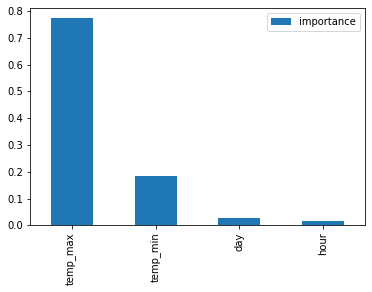

In [300]:
ax = feat_import[:20].plot(kind='bar')
ax.set_xticklabels(feat_import[:20]['feature'].tolist())

In [301]:
spark.stop()